This notebook is basic implementation of the blog
```
https://embracingtherandom.com/machine-learning/tensorflow/ranking/deep-learning/learning-to-rank-part-1/
```

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sentences = ["snoopy dog",
             "milo dog",
             "dumbo elephant",
             "portugal country",
             "brazil country"
             ]


In [4]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sentences)
print('Vocabulary is:')
print(tokenizer.word_index)

Vocabulary is:
{'dog': 1, 'country': 2, 'snoopy': 3, 'milo': 4, 'dumbo': 5, 'elephant': 6, 'portugal': 7, 'brazil': 8}


In [5]:
sequences = tokenizer.texts_to_sequences(sentences)

for x in sequences:
  print(x)

[3, 1]
[4, 1]
[5, 6]
[7, 2]
[8, 2]


In [7]:
VOCAB_SIZE = max(tokenizer.index_word) + 1
print(tokenizer.index_word)
print(f"Vocab Size is {VOCAB_SIZE}")

{1: 'dog', 2: 'country', 3: 'snoopy', 4: 'milo', 5: 'dumbo', 6: 'elephant', 7: 'portugal', 8: 'brazil'}
Vocab Size is 9


In [14]:
# for visualizing what it really does

for sequence in sequences:
  pairs_temp, labels_temp = tf.keras.preprocessing.sequence.skipgrams(
      sequence, VOCAB_SIZE, negative_samples = 1.0, window_size=1, shuffle=True
  )
pairs_temp, labels_temp

([[8, 3], [8, 2], [2, 8], [2, 2]], [0, 1, 1, 0])

## Objectives of Neural Network:
* Pull words together in sentences
* Push each word away from randomly chosen negative samples

In [17]:
def make_skipgrams():
  train_x, all_labels = [], []
  for sequence in sequences:
    pairs, labels = tf.keras.preprocessing.sequence.skipgrams(
      sequence, VOCAB_SIZE, negative_samples = 1.0, window_size=1, shuffle=True
    )
    train_x.extend(pairs)
    all_labels.extend(labels)

  train_x = np.array(train_x)
  all_labels = np.array(all_labels, dtype=np.float32)

  content_words = train_x[:, 0]
  context_words = train_x[:, 1]

  return content_words, context_words, all_labels

In [19]:
# inputs
content_input = tf.keras.layers.Input(shape=(1, ), dtype=tf.int32, name='content_word')
context_input = tf.keras.layers.Input(shape=(1, ), dtype=tf.int32, name='context_word')
context_input, content_input

(<KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'context_word')>,
 <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'content_word')>)

In [20]:
# layers
embeddings = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=2, name='embeddings')
dot_prod = tf.keras.layers.Dot(axes=2, normalize=True, name='dot_product')
embeddings, dot_prod

(<keras.src.layers.core.embedding.Embedding at 0x7b1c058c0d90>,
 <keras.src.layers.merging.dot.Dot at 0x7b1c058c3d90>)

In [21]:
# graph
content_embedding = embeddings(content_input)
context_embedding = embeddings(context_input)
content_embedding, context_embedding

(<KerasTensor: shape=(None, 1, 2) dtype=float32 (created by layer 'embeddings')>,
 <KerasTensor: shape=(None, 1, 2) dtype=float32 (created by layer 'embeddings')>)

In [22]:
cosine_sim = tf.keras.layers.Flatten(name='flatten')(dot_prod([content_embedding, context_embedding]))
dense_out = tf.keras.layers.Dense(1, activation='sigmoid', name='sigmoid_out')(cosine_sim)
cosine_sim, dense_out

(<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sigmoid_out')>)

In [23]:
model = tf.keras.models.Model(inputs = [content_input, context_input], outputs = [dense_out])
model

In [25]:
# DECAY_RATE = 5e-6
LR = 0.1

optimiser = tf.keras.optimizers.SGD(learning_rate=LR)
model.compile(loss='binary_crossentropy', optimizer=optimiser, metrics=['accuracy'])

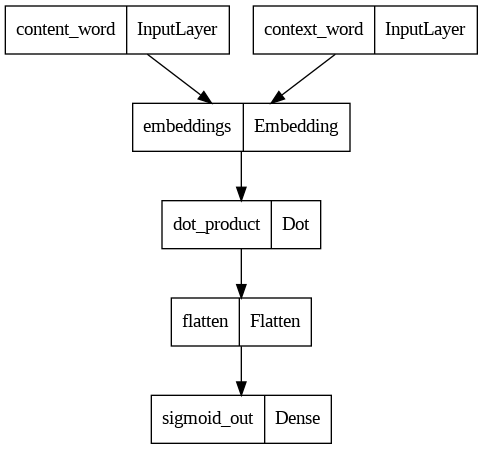

In [26]:
tf.keras.utils.plot_model(model)

Loss: 0.5824
Loss: 0.5651
Loss: 0.5015
Loss: 0.5687
Loss: 0.5171
Loss: 0.5569
Loss: 0.5892
Loss: 0.4933
Loss: 0.4315
Loss: 0.6115
Loss: 0.4292
Loss: 0.4288
Loss: 0.5394
Loss: 0.5428
Loss: 0.4490
Loss: 0.5510
Loss: 0.5407
Loss: 0.5018
Loss: 0.6257


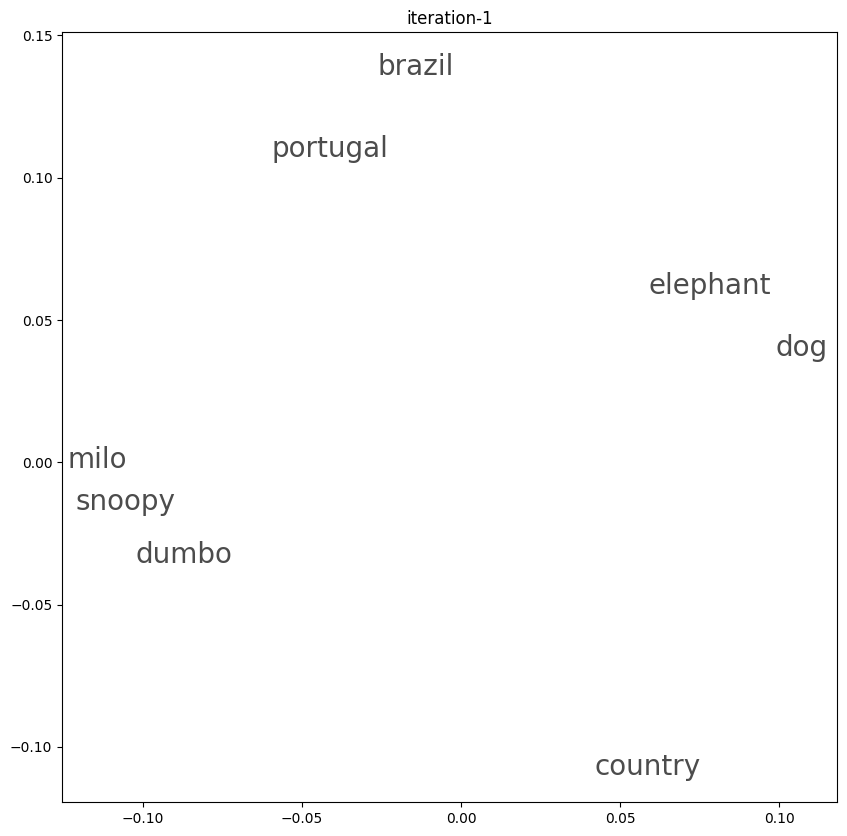

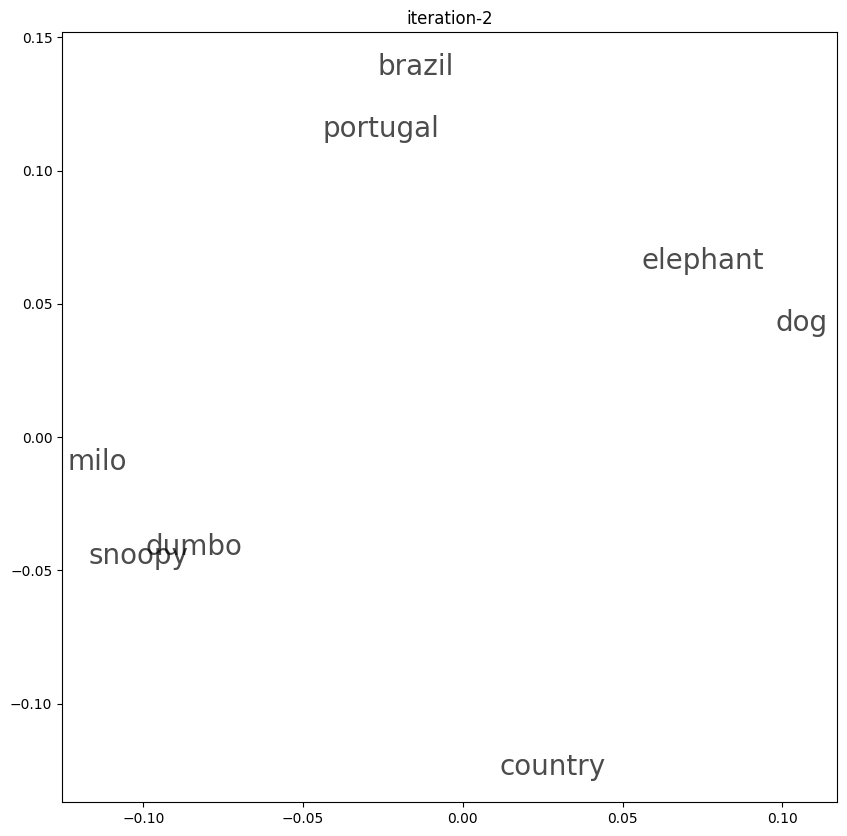

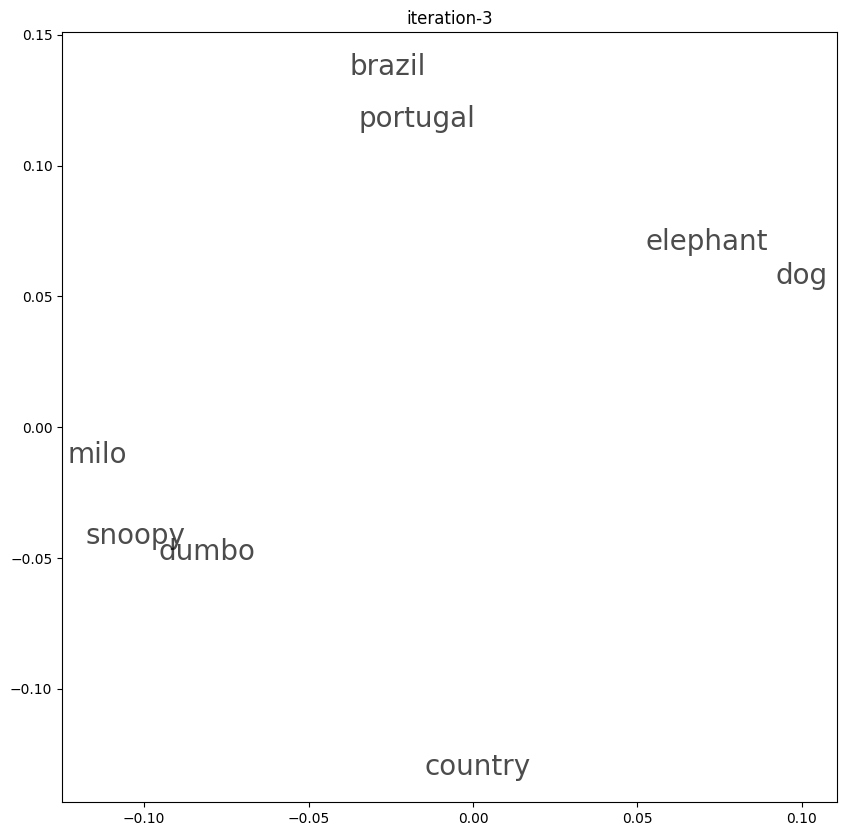

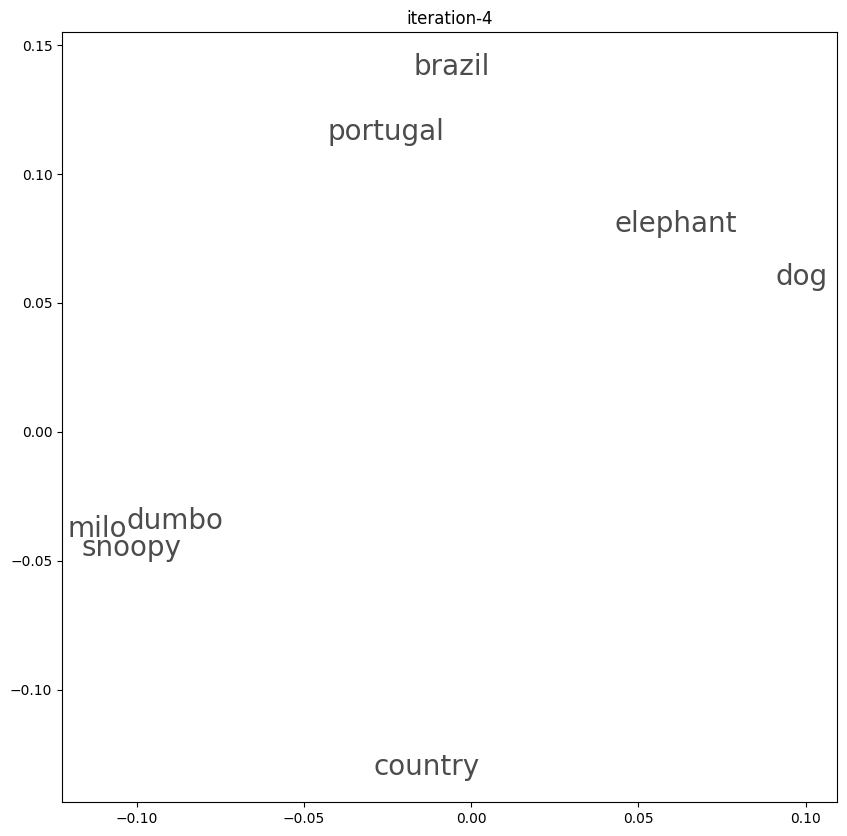

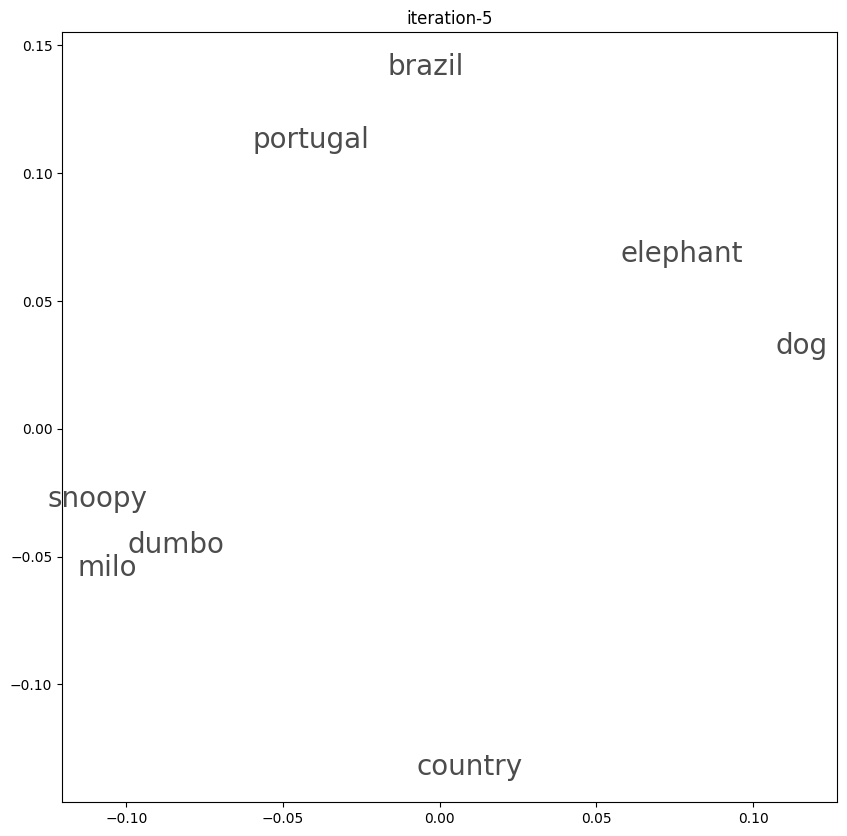

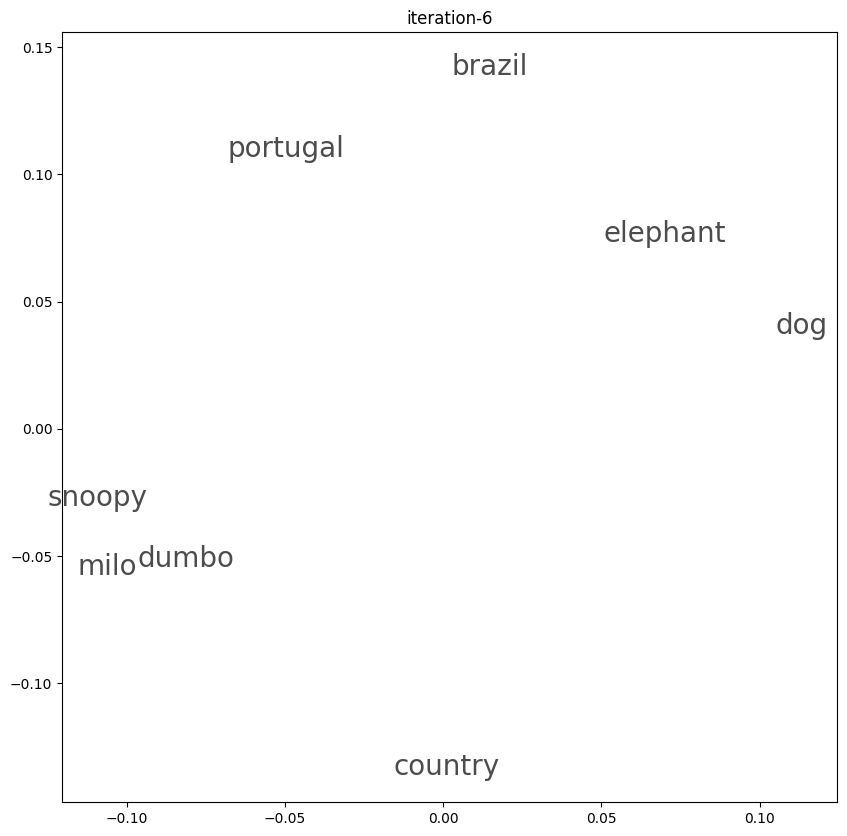

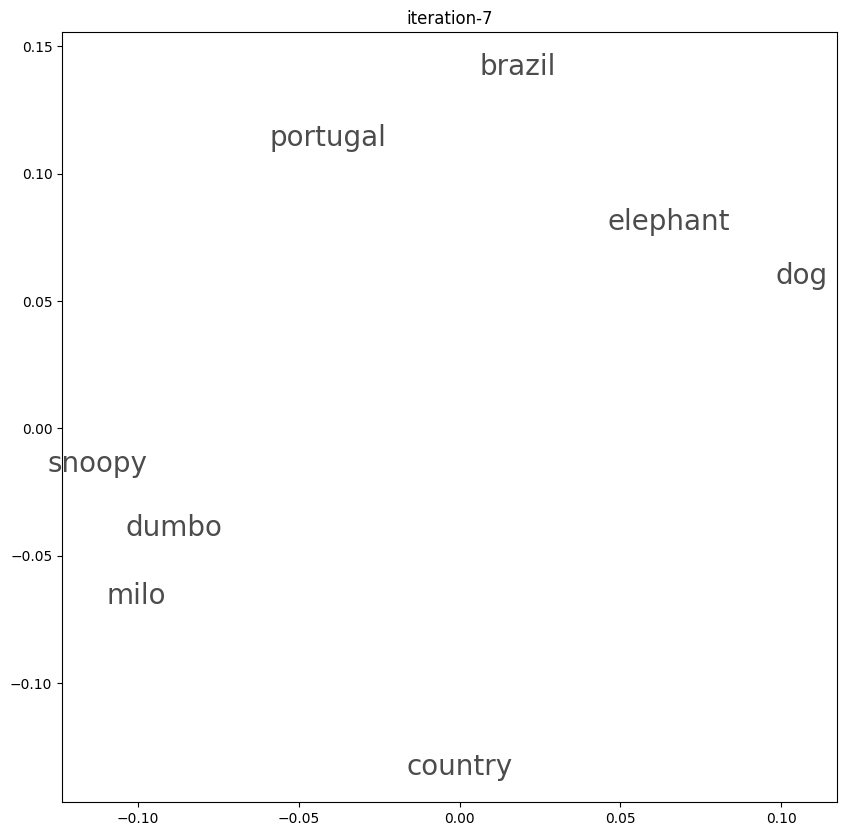

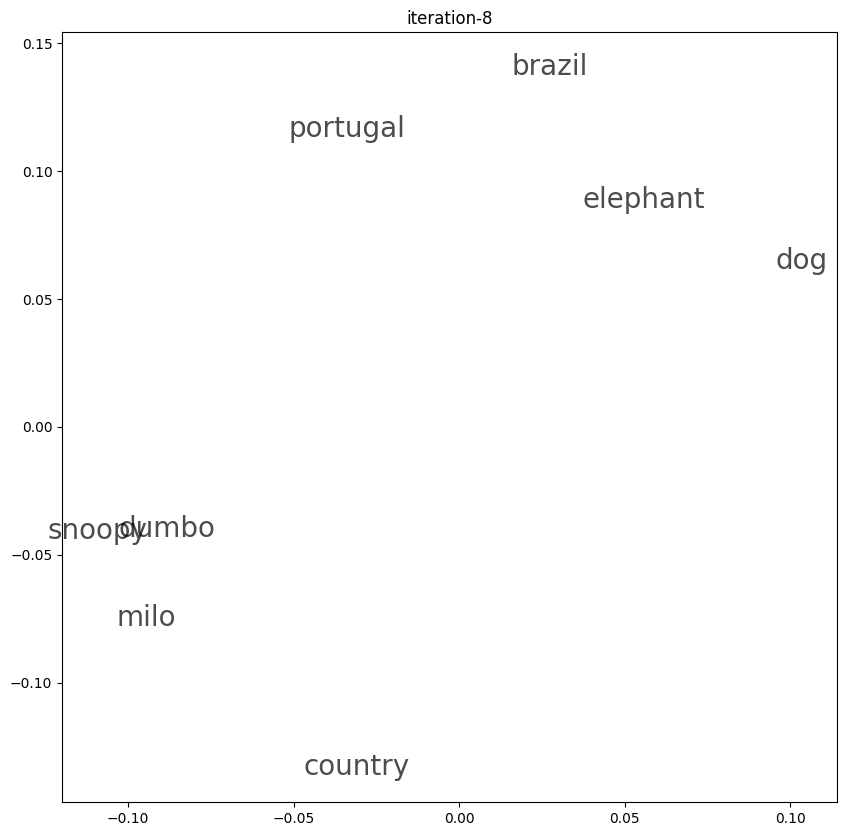

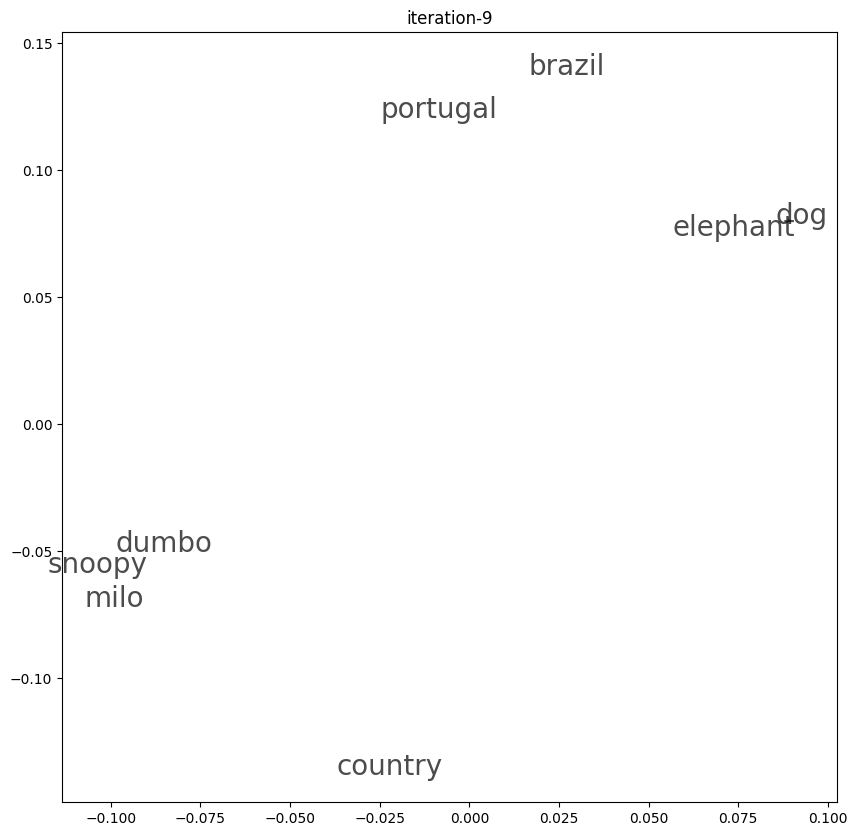

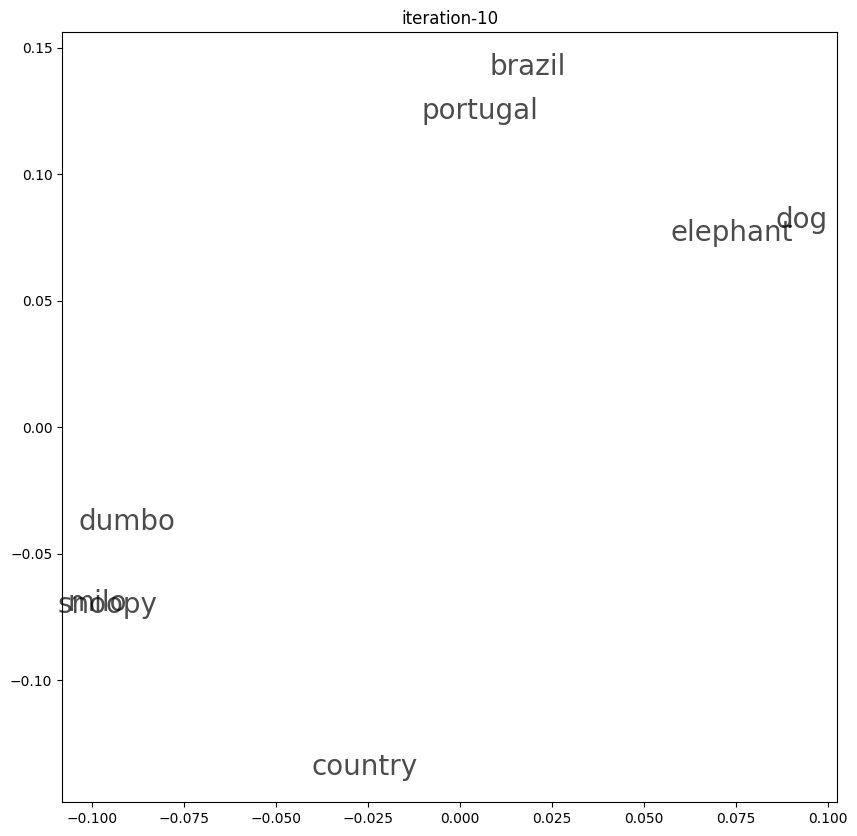

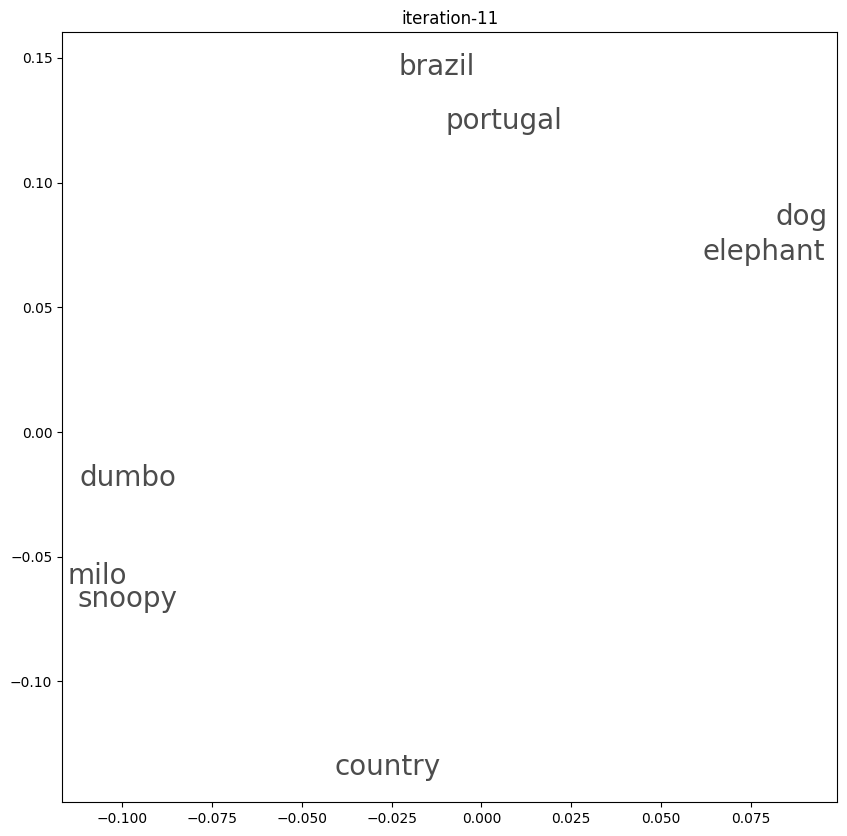

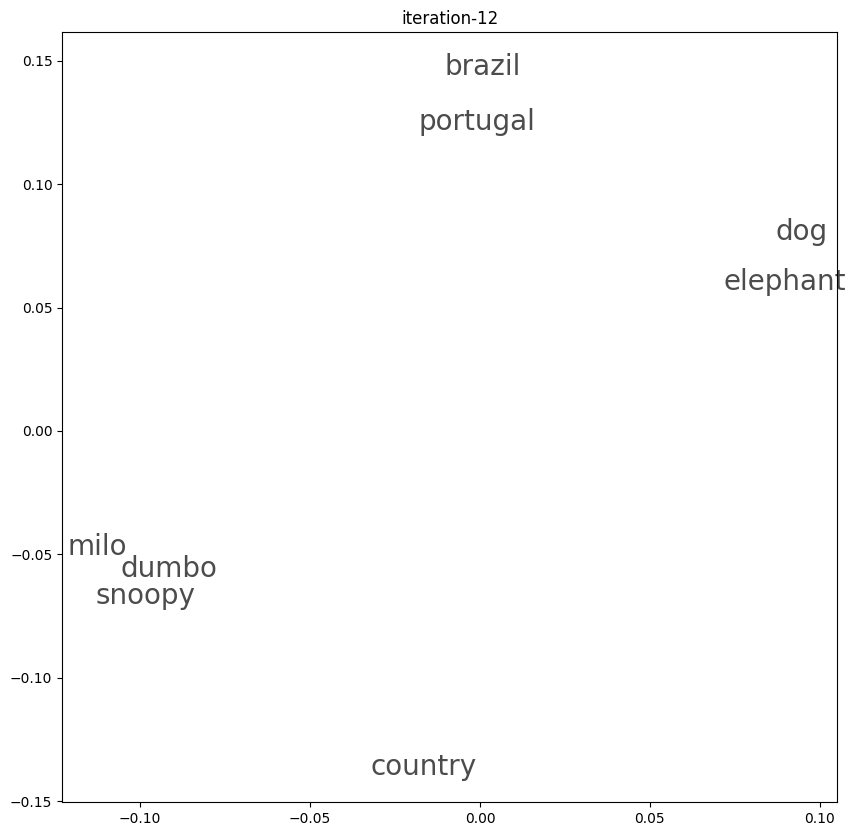

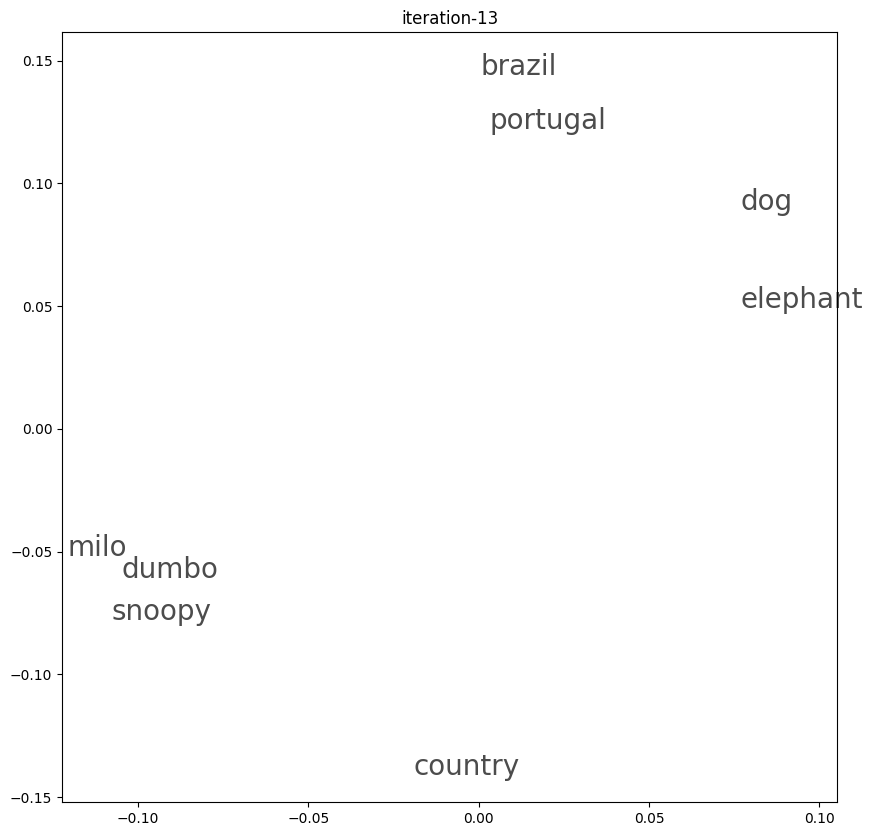

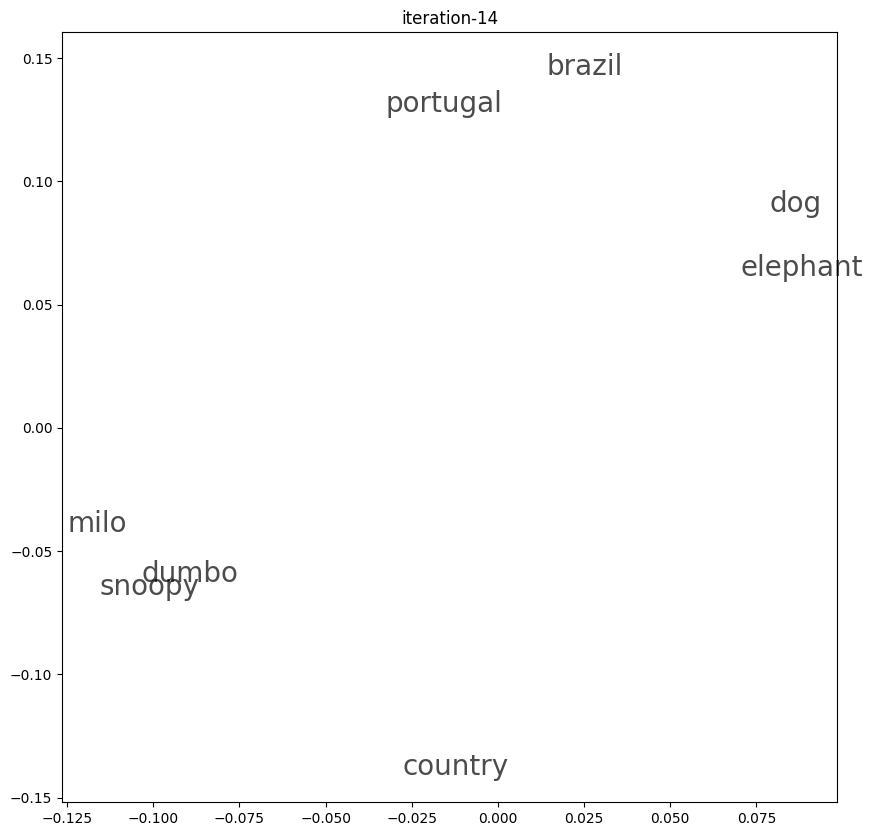

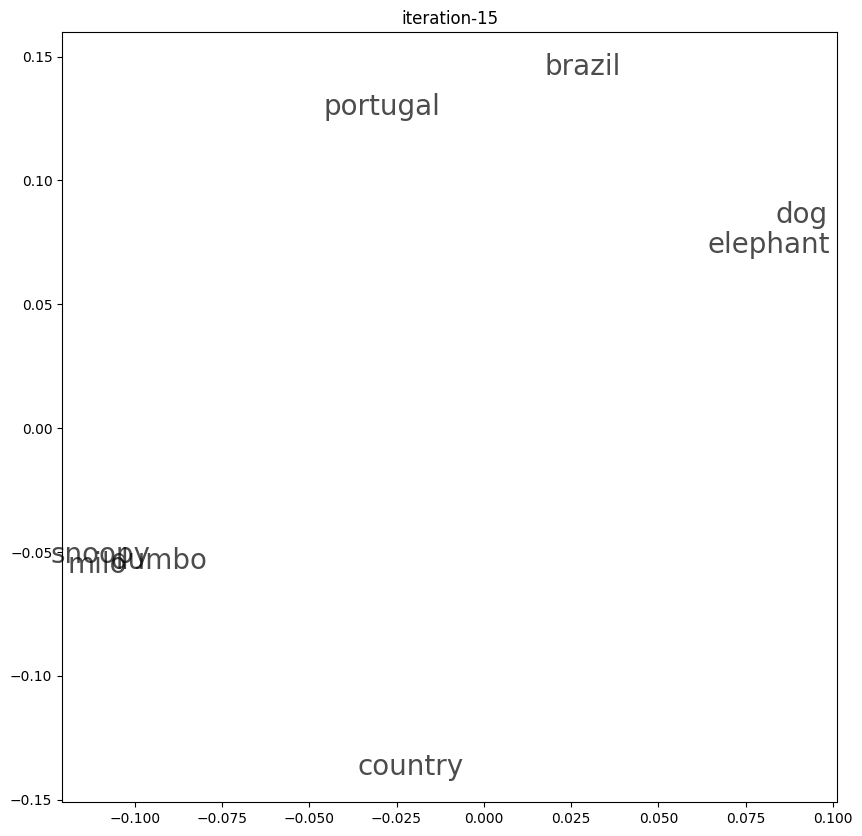

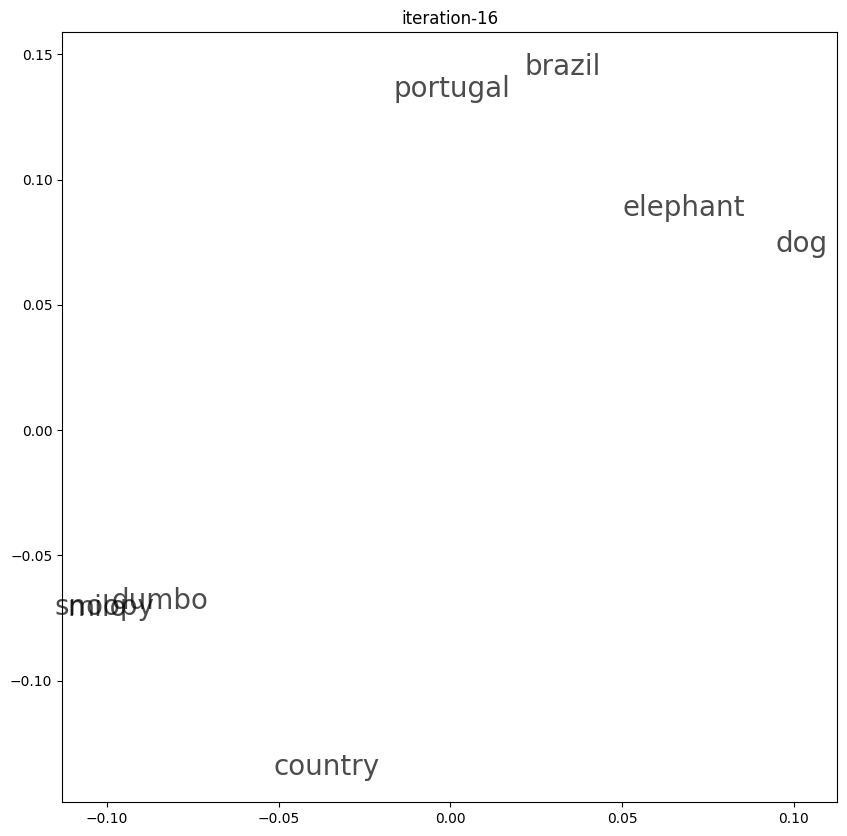

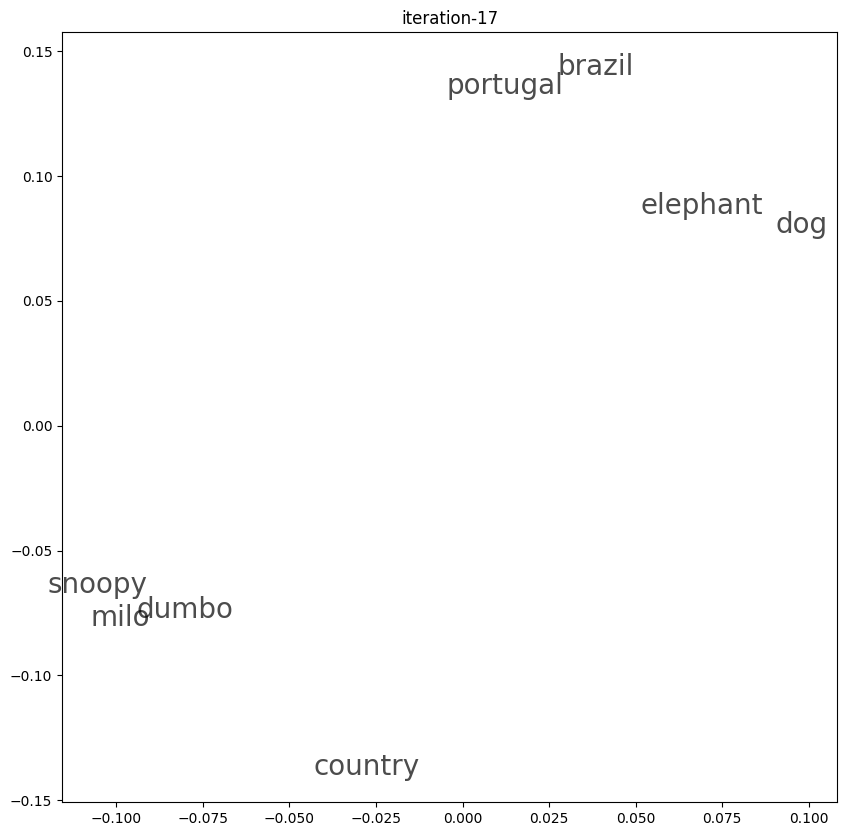

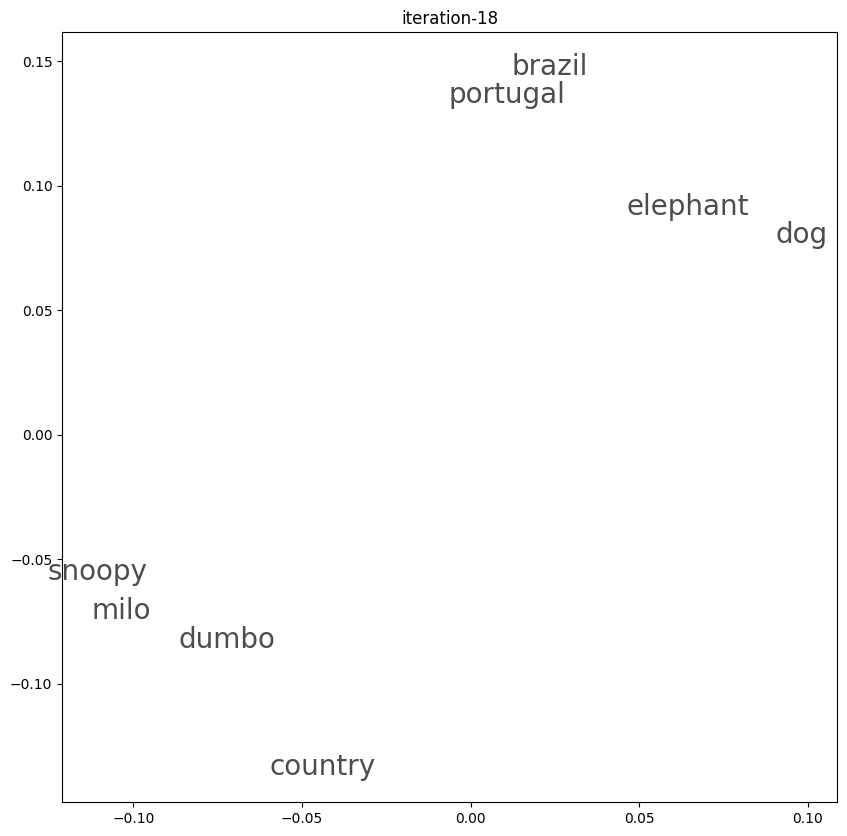

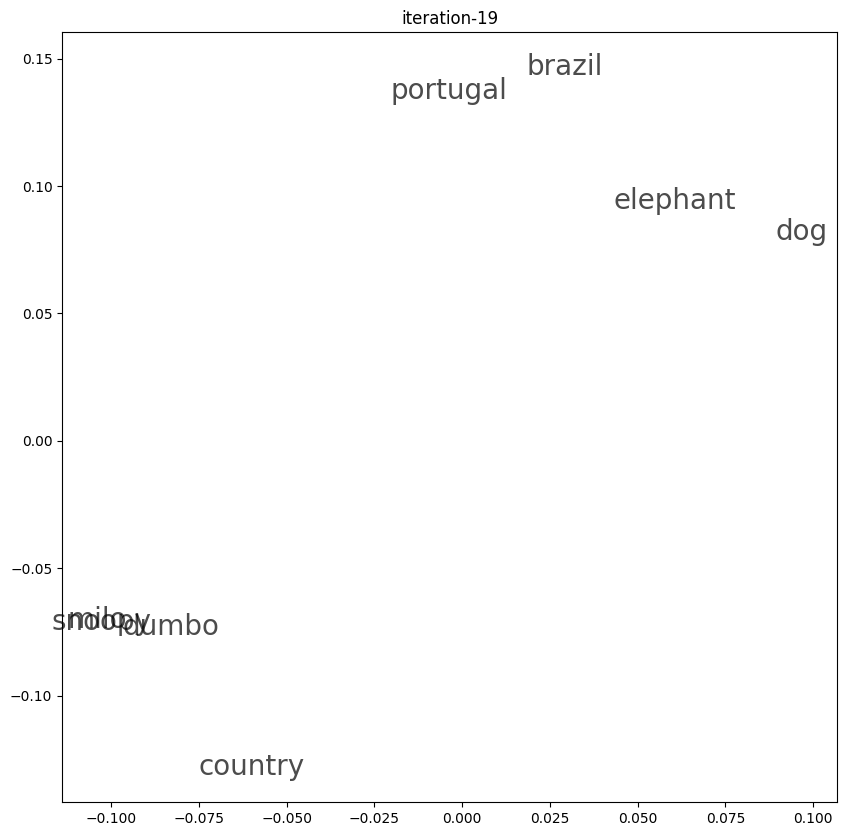

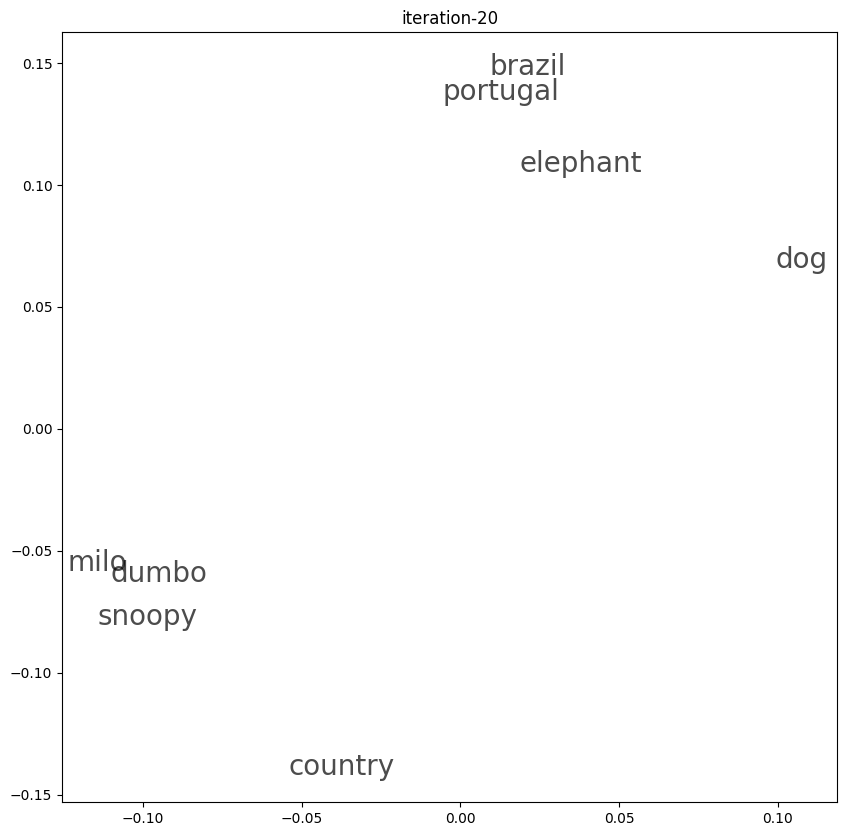

In [29]:
losses = []

for i in range(20):

  if i>0:
    content_words, context_words, labels = make_skipgrams()

    history = model.fit([content_words, context_words], labels, epochs = 1, verbose = 0)
    print(f"Loss: {history.history['loss'][-1]:.4f}")
    losses.extend(history.history['loss'])

  embedding_vectors = np.array(embeddings.weights[0].numpy())

  fig, ax = plt.subplots(figsize=(10,10))

  ax.scatter(embedding_vectors[1:, 0], embedding_vectors[1:, 1],  c='white')

  for idx, word in sorted(tokenizer.index_word.items()):
    x_coord = embedding_vectors[idx, 0]
    y_coord = embedding_vectors[idx, 1]

    ax.annotate(
        word,
        (x_coord, y_coord),
        horizontalalignment='center',
        verticalalignment='center',
        size=20,
        alpha=0.7
    )

    ax.set_title(f"iteration-{i+1}")

plt.savefig(f"iteration-{i+1:03d}.jpg")